In [1]:
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from utils.GNN_data import *
from utils.GNN_model import GIN
from utils.train_model import train_model
from utils.evaluate_model import *

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch_num', type=int, default=64, help='batch size') 
parser.add_argument('--epoch_num', type=int, default=200, help='Epoch number') 
parser.add_argument('--cover_interval', type=int, default=20, help='Cover interval')
parser.add_argument('--overlap', type=float, default=0.3, help='cover overlap')
parser.add_argument('--save_model_dir', type=str, default='./examples/saved_GNN_model', help='saved GNN model directory')
args = parser.parse_args([])

In [3]:
from torch_geometric.data import Data
import torch 
def load_inp_data(file_path, label):
    nodes, edges = [], []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

        node_section = False
        element_section = False

        for line in lines:
            line = line.strip()

            if "*Node" in line:
                node_section = True
                element_section = False
                continue

            if "*Element" in line:
                node_section = False
                element_section = True
                continue

            # Skip invalid lines like "*Nset" or "*Elset"
            if "*Nset" in line or "*Elset" in line:
                node_section = False
                element_section = False
                continue

            if node_section:
                parts = line.split(',')
                if len(parts) >= 3:
                    try:
                        x, y = float(parts[1].strip()), float(parts[2].strip())
                        nodes.append([x, y])
                    except ValueError:
                        continue

            if element_section:
                parts = line.split(',')
                if len(parts) >= 3 and parts[0].strip().isdigit() and parts[1].strip().isdigit() and parts[2].strip().isdigit():
                    start, end = int(parts[1].strip()) - 1, int(parts[2].strip()) - 1  # Convert 1-indexed to 0-indexed
                    
                    if start == end:
                        continue
                    
                    # Ensure indices are within valid range
                    if start < len(nodes) and end < len(nodes):
                        edges.append([start, end])
                    else:
                        print(f"Skipping invalid edge ({start+1}, {end+1}) in {file_path}")

    node_tensor = torch.tensor(nodes, dtype=torch.float)
    edge_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

    data = Data(x=node_tensor, edge_index=edge_tensor, K=np.float64(label * 200000.00))
    return data

# Data loading

In [4]:
import glob

# Read the Result.txt file and extract filenames and their labels
file_labels = {}
with open('Results.txt', 'r') as file:
    for line in file:
        # Skip empty lines or lines starting with a header
        if line.strip() == "" or "E/Es" in line:
            continue
        
        try:
            file, label = line.strip().split(', ')
            filename, filetype = file.strip().split('.')
            label = float(label)  # Convert the label to a float
            file_labels[filename] = label
        except ValueError:
            print(f"Skipping line due to invalid format: {line.strip()}")

# Load all data points using the filenames and labels from the file_labels dictionary
dataset = [load_inp_data(f"inp_files/{file}.inp", label) for file, label in file_labels.items()]

# Print out the loaded data
for file, label in file_labels.items():
    print(f"Filename: {file}, E/Es: {label}")

Filename: Kag10L_R00_n01, E/Es: 0.0166712805176
Filename: Kag10L_R01_n01, E/Es: 0.0165968310547
Filename: Kag10L_R01_n02, E/Es: 0.016587890625
Filename: Kag10L_R01_n03, E/Es: 0.0165587841797
Filename: Kag10L_R01_n04, E/Es: 0.0165454077148
Filename: Kag10L_R01_n05, E/Es: 0.0165114807129
Filename: Kag10L_R01_n06, E/Es: 0.0165991699219
Filename: Kag10L_R01_n07, E/Es: 0.0166008166504
Filename: Kag10L_R01_n08, E/Es: 0.0165159558105
Filename: Kag10L_R01_n09, E/Es: 0.0165478527832
Filename: Kag10L_R01_n10, E/Es: 0.0165925073242
Filename: Kag10L_R01_n11, E/Es: 0.0166401220703
Filename: Kag10L_R01_n12, E/Es: 0.0165739355469
Filename: Kag10L_R01_n13, E/Es: 0.0165640649414
Filename: Kag10L_R01_n14, E/Es: 0.016555604248
Filename: Kag10L_R01_n15, E/Es: 0.0165907177734
Filename: Kag10L_R01_n16, E/Es: 0.0164631066895
Filename: Kag10L_R01_n17, E/Es: 0.0164945996094
Filename: Kag10L_R01_n18, E/Es: 0.01650796875
Filename: Kag10L_R01_n19, E/Es: 0.016533104248
Filename: Kag10L_R01_n20, E/Es: 0.01658396484

In [5]:
dataset

[Data(x=[104, 2], edge_index=[2, 180], K=3334.25610352),
 Data(x=[104, 2], edge_index=[2, 180], K=3319.36621094),
 Data(x=[104, 2], edge_index=[2, 180], K=3317.578125),
 Data(x=[104, 2], edge_index=[2, 180], K=3311.75683594),
 Data(x=[104, 2], edge_index=[2, 180], K=3309.0815429599998),
 Data(x=[104, 2], edge_index=[2, 180], K=3302.2961425800004),
 Data(x=[104, 2], edge_index=[2, 180], K=3319.8339843800004),
 Data(x=[104, 2], edge_index=[2, 180], K=3320.16333008),
 Data(x=[104, 2], edge_index=[2, 180], K=3303.1911621),
 Data(x=[104, 2], edge_index=[2, 180], K=3309.5705566399997),
 Data(x=[104, 2], edge_index=[2, 180], K=3318.5014648399997),
 Data(x=[104, 2], edge_index=[2, 180], K=3328.02441406),
 Data(x=[104, 2], edge_index=[2, 180], K=3314.78710938),
 Data(x=[104, 2], edge_index=[2, 180], K=3312.81298828),
 Data(x=[104, 2], edge_index=[2, 180], K=3311.1208496),
 Data(x=[104, 2], edge_index=[2, 180], K=3318.1435546800003),
 Data(x=[104, 2], edge_index=[2, 180], K=3292.6213379),
 Data(

In [6]:
batch_size = args.batch_num
epoch_num = args.epoch_num 
learning_rate = 0.005
overlap=args.overlap

# Check if the graph data is directed or undirected. For this study, undirected edges are used.
all_undirected_before = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (before conversion): {all_undirected_before}')  # True if all are undirected, False otherwise

# Convert all graphs in the dataset to undirected
dataset = [make_undirected(data) for data in dataset]

# Re-check if all graphs are now undirected
all_undirected_after = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (after conversion): {all_undirected_after}')  # True if all are undirected, False otherwise

dataset = normalize_planar_info(dataset)

# Split dataset for train/validation/test
train_loader, test_loader, valid_loader = prepare_dataset(dataset, batch_size, train_percentage=0.80, test_percentage=0.1)

Graphs are undirected (before conversion): False
Graphs are undirected (after conversion): True
Number of training graphs: 800
Number of test graphs: 100
Number of vali graphs: 101


In [7]:
dataset

[Data(x=[104, 2], edge_index=[2, 360], K=3334.25610352),
 Data(x=[104, 2], edge_index=[2, 360], K=3319.36621094),
 Data(x=[104, 2], edge_index=[2, 360], K=3317.578125),
 Data(x=[104, 2], edge_index=[2, 360], K=3311.75683594),
 Data(x=[104, 2], edge_index=[2, 360], K=3309.0815429599998),
 Data(x=[104, 2], edge_index=[2, 360], K=3302.2961425800004),
 Data(x=[104, 2], edge_index=[2, 360], K=3319.8339843800004),
 Data(x=[104, 2], edge_index=[2, 360], K=3320.16333008),
 Data(x=[104, 2], edge_index=[2, 360], K=3303.1911621),
 Data(x=[104, 2], edge_index=[2, 360], K=3309.5705566399997),
 Data(x=[104, 2], edge_index=[2, 360], K=3318.5014648399997),
 Data(x=[104, 2], edge_index=[2, 360], K=3328.02441406),
 Data(x=[104, 2], edge_index=[2, 360], K=3314.78710938),
 Data(x=[104, 2], edge_index=[2, 360], K=3312.81298828),
 Data(x=[104, 2], edge_index=[2, 360], K=3311.1208496),
 Data(x=[104, 2], edge_index=[2, 360], K=3318.1435546800003),
 Data(x=[104, 2], edge_index=[2, 360], K=3292.6213379),
 Data(

# GNN architecture

In [8]:
# Define the model, optimizer, and loss function

no_node_feature = dataset[0].x.shape[1]
model = GIN(dim_h=64, node_feature=no_node_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()
print(model)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=192, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=128, bias=True)
  (lin4): Linear(in_features=1

/root/miniconda3/envs/GNN_ElasticModulus_Prediction/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training

In [9]:
train_losses, test_losses, R2_trainings, R2_tests, best_state_dict = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device=device, num_epochs=epoch_num)

Epoch [1], Loss[Train: 2676992.375, Test: 8705584.400], R2[Train: -2.425, Test: -9.665]
Epoch [2], Loss[Train: 1702017.215, Test: 850254.820], R2[Train: -1.178, Test: -0.042]
Epoch [3], Loss[Train: 803034.440, Test: 759030.635], R2[Train: -0.027, Test: 0.070]
Epoch [4], Loss[Train: 797287.312, Test: 1046518.300], R2[Train: -0.020, Test: -0.282]
Epoch [5], Loss[Train: 967648.245, Test: 770215.435], R2[Train: -0.238, Test: 0.056]
Epoch [6], Loss[Train: 768130.427, Test: 765099.608], R2[Train: 0.017, Test: 0.063]
Epoch [7], Loss[Train: 751618.169, Test: 738085.390], R2[Train: 0.038, Test: 0.096]
Epoch [8], Loss[Train: 709614.877, Test: 710963.655], R2[Train: 0.092, Test: 0.129]
Epoch [9], Loss[Train: 715481.805, Test: 697442.190], R2[Train: 0.085, Test: 0.146]
Epoch [10], Loss[Train: 815544.483, Test: 728031.635], R2[Train: -0.043, Test: 0.108]
Epoch [11], Loss[Train: 676638.780, Test: 735837.170], R2[Train: 0.134, Test: 0.099]
Epoch [12], Loss[Train: 799011.710, Test: 634653.635], R2[Tra

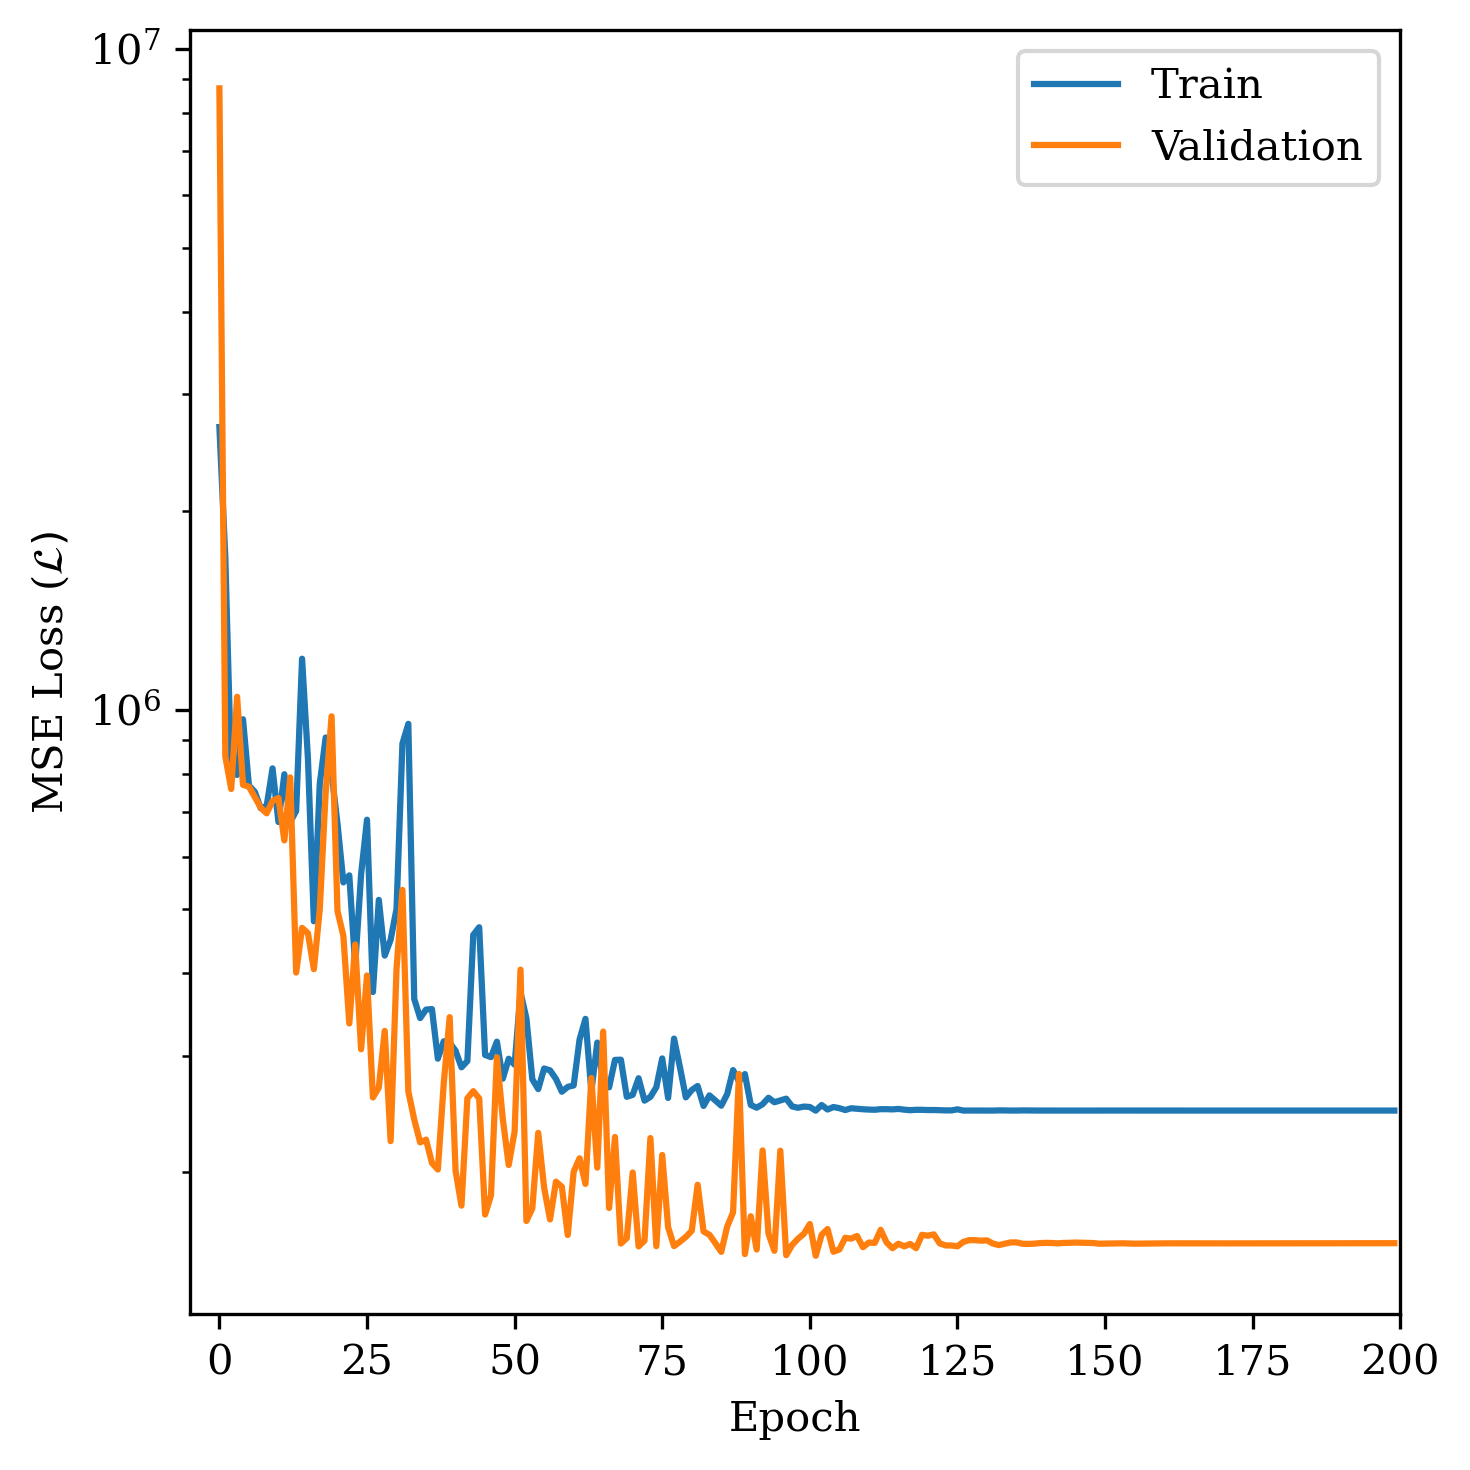

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Epoch vs R^2
plt.figure(dpi=300, figsize=(5,5)) 

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 10

plt.plot(np.array(train_losses), label='Train')
plt.plot(np.array(test_losses), label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'MSE Loss ($\mathcal{L})$')
plt.yscale("log") 
plt.xlim(-5,epoch_num)
plt.tight_layout() 

# Save model

In [11]:
best_model_path = f'{args.save_model_dir}/epoch_{args.epoch_num}.pt'  
torch.save(best_state_dict, best_model_path)

# Evaluation

Test R2 for E: 0.4546278119087219


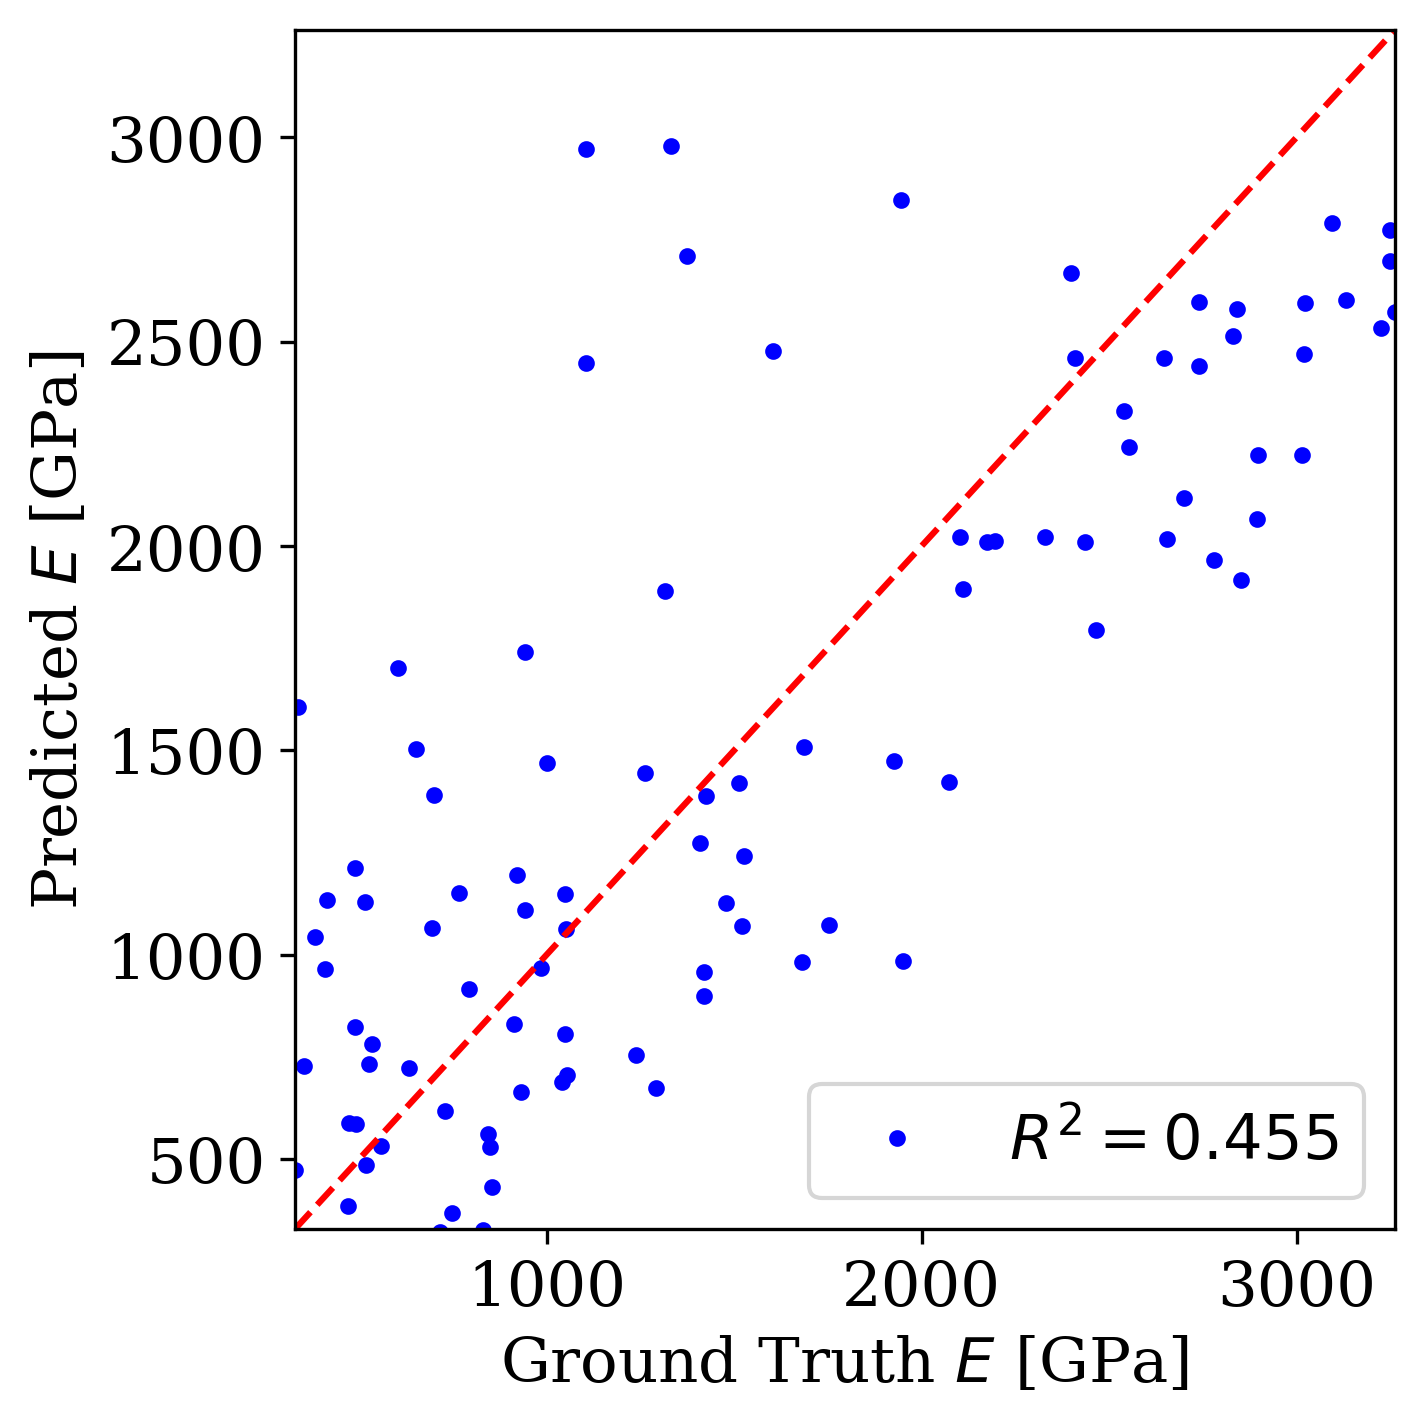

In [12]:
R2_K = evaluate_model(model, valid_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.6830651760101318


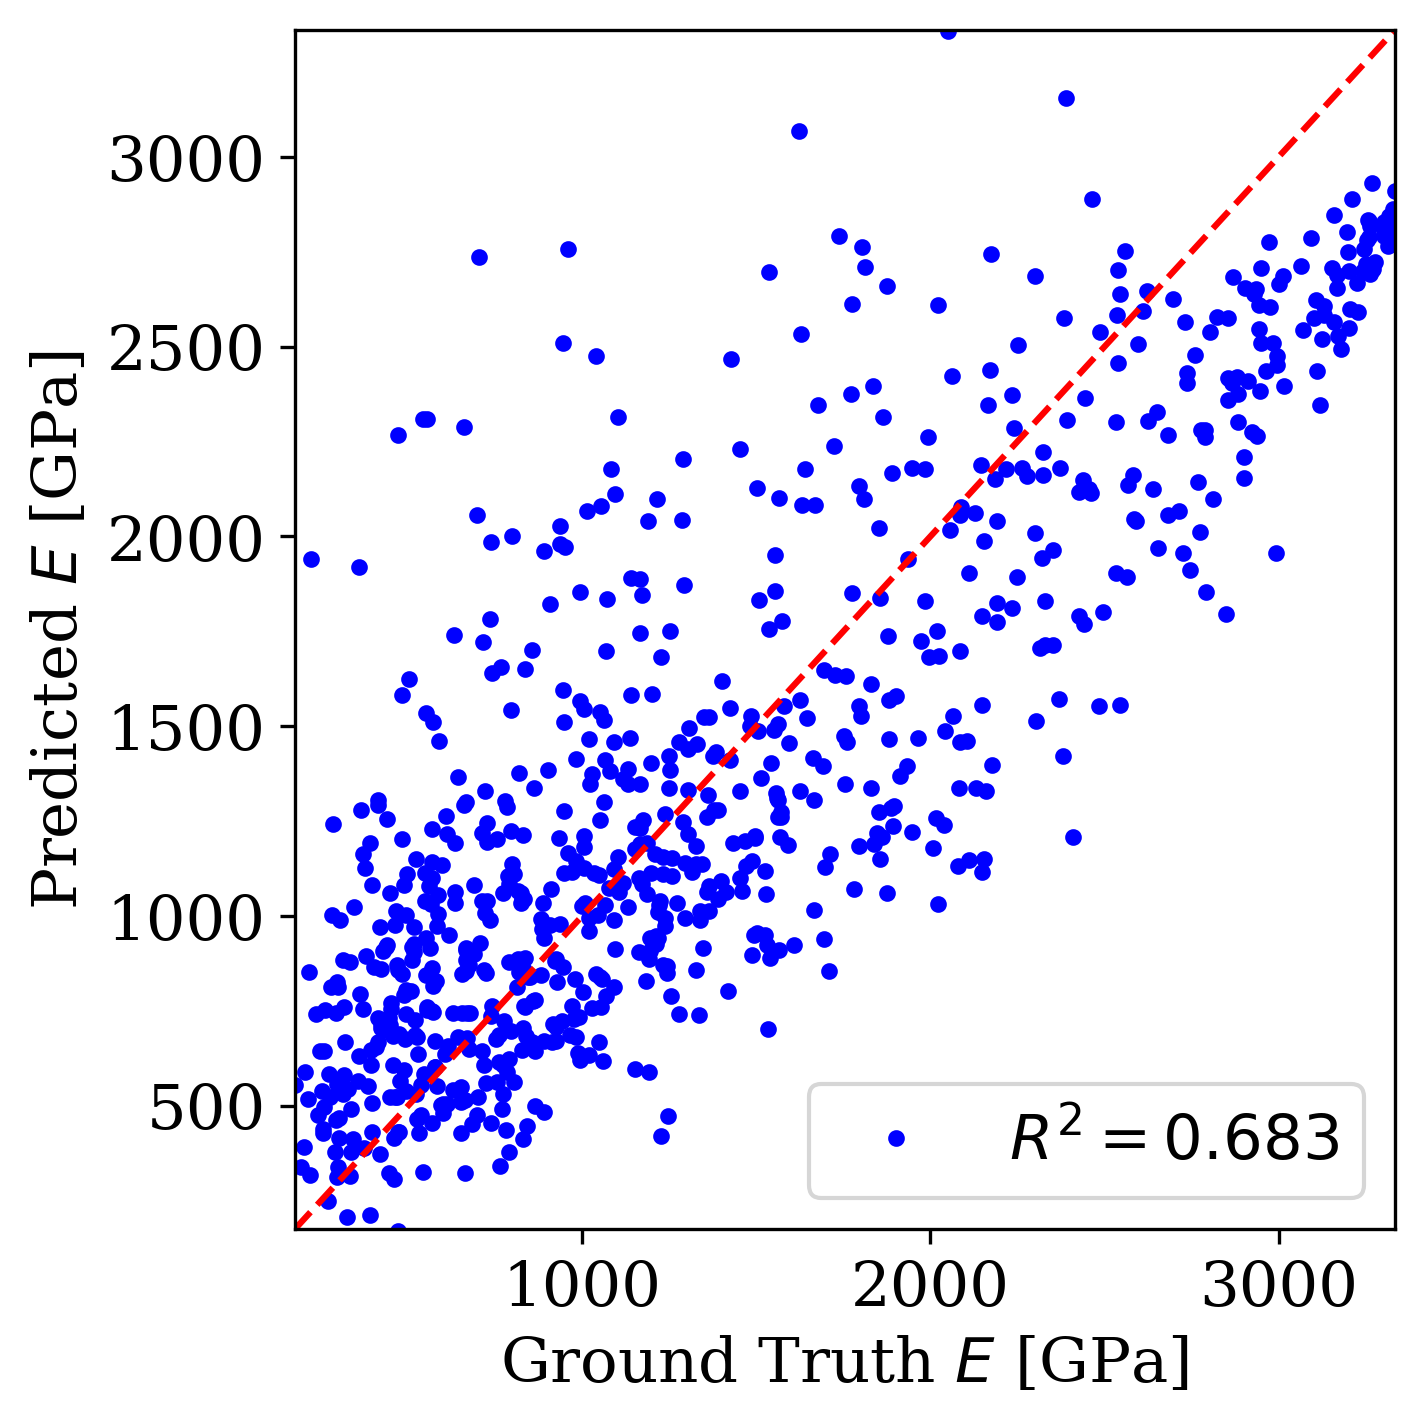

In [13]:
R2_K = evaluate_model(model, train_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.808750331401825


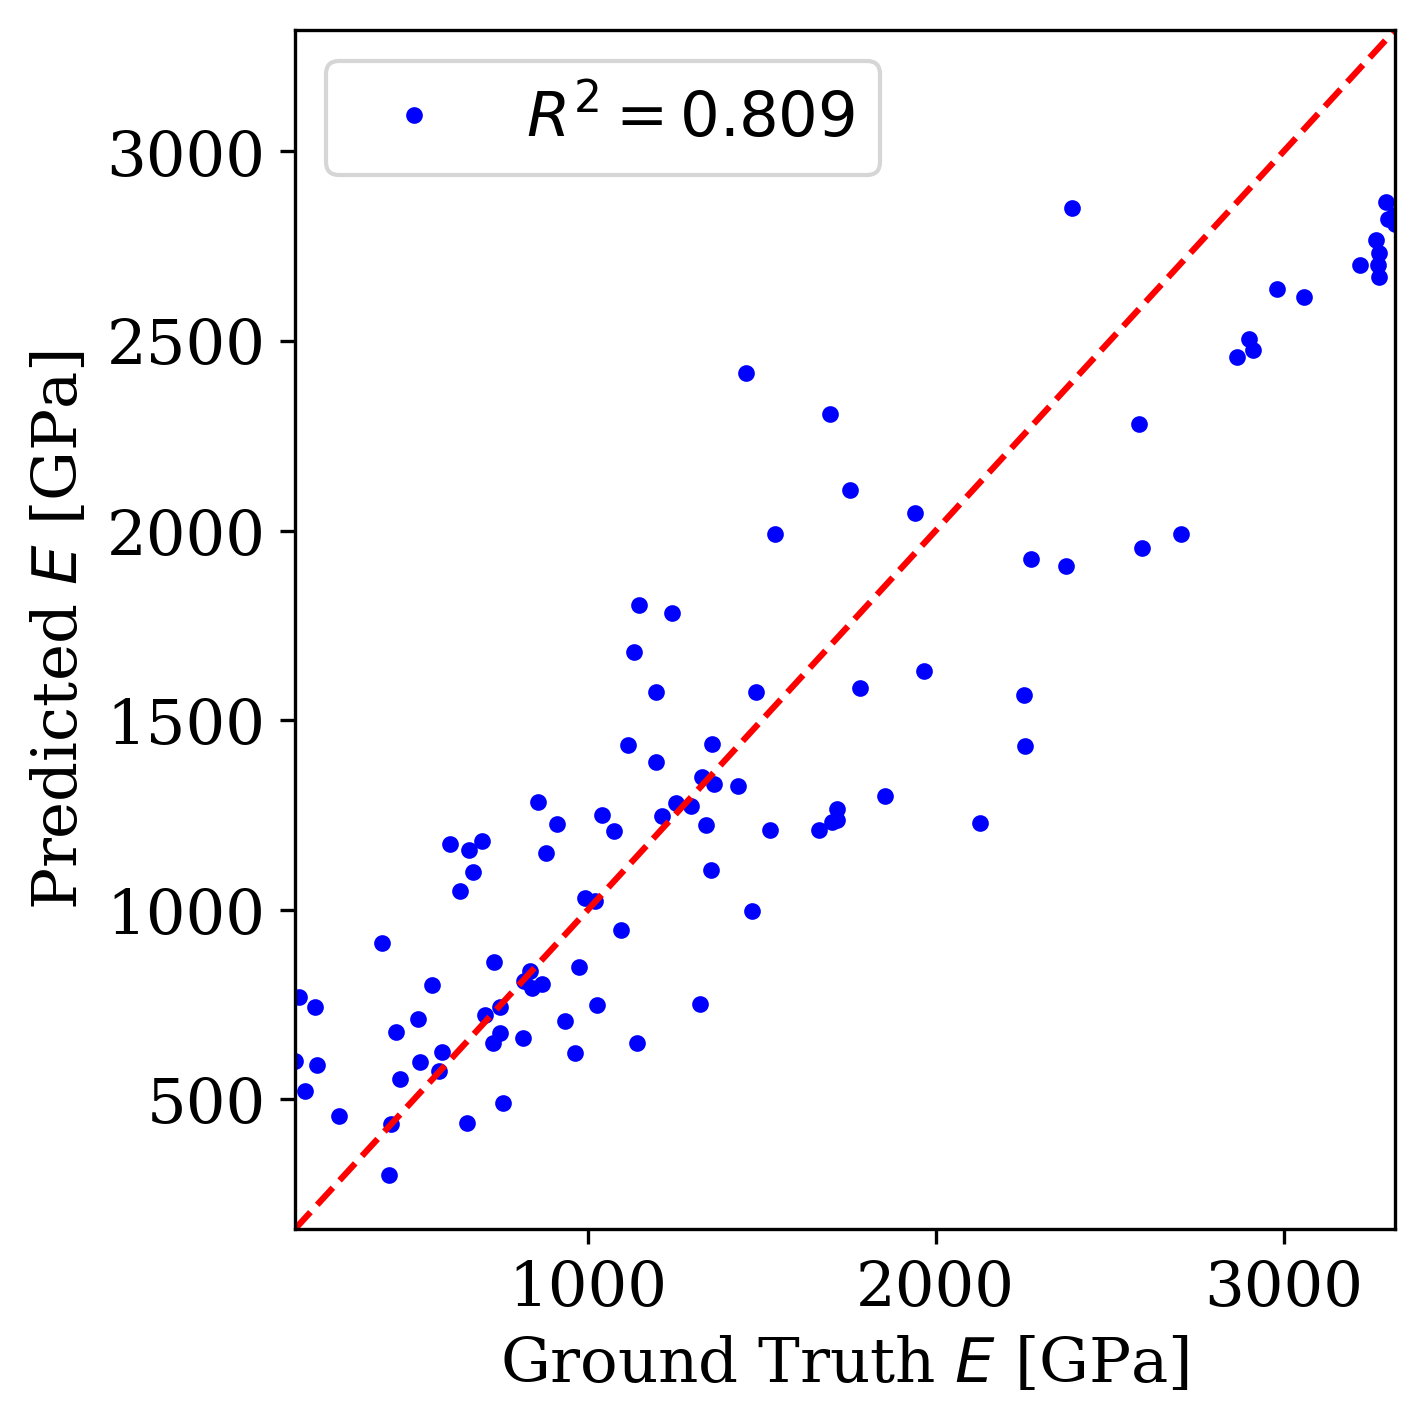

In [14]:
R2_K = evaluate_model(model, test_loader, device, args.cover_interval, overlap, args.save_model_dir)